In [79]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [80]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Loading data functions

In [81]:
def load_data(in_file):
    input_f = open(in_file, "r")
    matrix = []
    for line in input_f:
        channels = [] #get channels
        for l in line.split("|"):
            samples = l.split(";")
            channels.append([float(i) for i in samples])
        matrix.append(channels)
        del channels
    input_f.close()
    return matrix

In [82]:
def load_labels(in_file):
    input_f = open(in_file, "r")
    labels = []
    for line in input_f:
        if ";" in line:
            labels.append(set(line.replace("\n","").split(";")))
        else:
            labels.append(line.replace("\n",""))
    input_f.close()
    return labels

In [83]:
from sklearn.preprocessing import MultiLabelBinarizer

def load_dataset():
    X_train_data = load_data("data/data_train.txt")
    y_train_lat_labels = load_labels("data/labels_train.txt")
    print ("initial data: ", np.array(X_train_data).shape)

    X_test_data = load_data("data/data_test.txt")
    y_test_lat_labels = load_labels("data/labels_test.txt")
    y_test_lat_labels = ["_with_".join(i) for i in y_test_lat_labels]
    print ("initial data: ", np.array(X_test_data).shape)
    
    ##########################################
    X_train_big = []
    X_train_big.extend(X_train_data)
    X_train_big.extend(X_test_data)
    X_train_big = np.array(X_train_big)

    y_train_lat_big = []
    y_train_lat_big.extend(y_train_lat_labels)
    y_train_lat_big.extend(y_test_lat_labels)
    
    y_train_lat_big_list = []
    for i in y_train_lat_big:
        if type(i) is list:
            y_train_lat_big_list.append(i)
        else:
            y_train_lat_big_list.append([i])

    mlb = MultiLabelBinarizer()
    y_train_big =  mlb.fit_transform(y_train_lat_big_list) 

    X_new_data = load_data("data/data_new.txt")
    print ("initial data: ", np.array(X_new_data).shape)
    return X_train_big, y_train_big, X_new_data, mlb

# Other functions

In [84]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    plt.figure(figsize=(9,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

   # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [85]:
from sklearn.cross_validation import KFold
def model_evaluation(X_train, y_train, N): 
    return KFold(n=len(X_train), shuffle=True, n_folds=N, random_state=42)       

In [86]:
def get_dfmax(X):
    X_max = []
    S_max = []
    for x in X:
        s_m = []
        for s in x:
            s_m.append(max(np.array(s)))
        S_max.append(s_m)
    for x,s_max in zip(X,S_max):        
        #print ("s_max: ", s_max)
        m = list(map(list, zip(*x))) 
        X_m = []
        for s in m:
            s_new = []
            for i,ss in zip(s,s_max):
                if i != ss:
                    s_new.append(0)
                else:
                    s_new.append(i)
            X_m.append(s_new)
        X_max.append(X_m)
    return X_max

# Working block

# Learning on raw data

Загрузим данные.
<br> X_train содержит вещества-маркеры и их смеси, X_new - это игрушки.
<br> y_train_bin - это метки классов обучающей выборки в multilabel-формате, y_train - те же метки, что только в виде названий веществ.

In [87]:
X_train, y_train_bin, X_new, mlb = load_dataset()

y_train2 = load_labels("data/labels_all.txt")
y_train = []
for item in y_train2:
    y_train.append([item])
y_train = mlb.fit_transform(y_train)

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)


In [88]:
X_train_raw = X_train
X_train_raw = np.array(X_train_raw)
n_samples = len(X_train_raw)
X_train_raw = X_train_raw.reshape((n_samples, -1))

In [89]:
X_new_raw = X_new
X_new_raw = np.array(X_new_raw)
n_samples = len(X_new_raw)
X_new_raw = X_new_raw.reshape((n_samples, -1))

In [90]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_raw, y_train2)
y_score = clf.predict(X_train_raw)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.95


Отличная точность! Проблемы только с гексаном и ДОФ с ацетоном - SVM принимает их за ДОФ.

Confusion matrix, without normalization


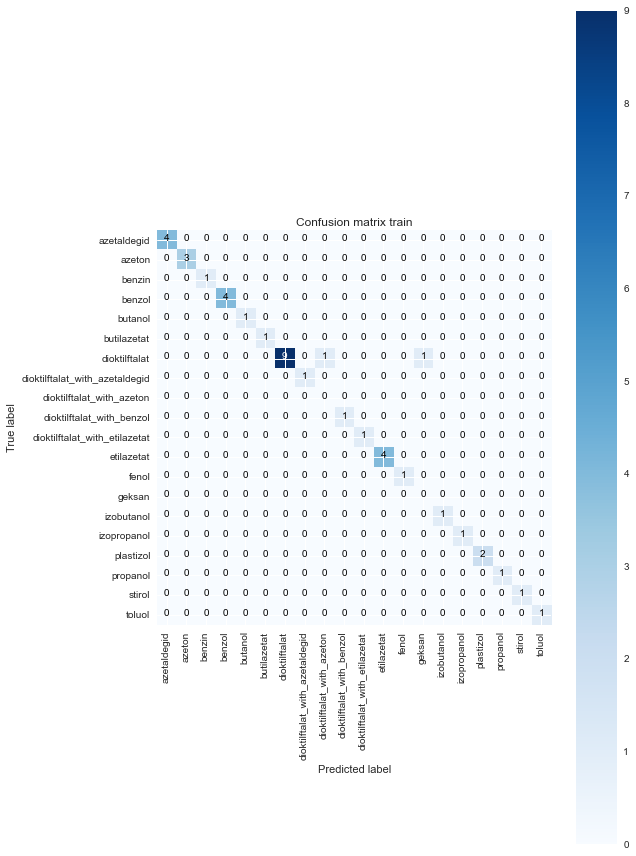

In [91]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(clf.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       1.00      1.00      1.00         4
                        azeton       1.00      1.00      1.00         3
                        benzin       1.00      1.00      1.00         1
                        benzol       1.00      1.00      1.00         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       0.82      1.00      0.90         9
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       0.00      0.00      0.00         1
     dioktilftalat_with_benzol       1.00      1.00      1.00         1
 dioktilftalat_with_etilazetat       1.00      1.00      1.00         1
                    etilazetat       1.00      1.00      1.00         4
                         fenol       1.00      1.00      1.00  

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Подберем параметры:

In [93]:
kfold = model_evaluation(X_train_raw, y_train2, 2)  

from sklearn.svm import SVC  
from sklearn.grid_search import GridSearchCV
Gammas = [0.001, 0.01, 1, 10]
kernels = ['rbf', 'linear', 'sigmoid']
decision_function = ['ovo', 'ovr']
coefs = [0.0, 0.5, 1.0, 10.0, 100.0]
class_weight = ['balanced', 'auto']
Cs = [0.001, 0.01, 1, 10]

svc_grid = GridSearchCV(estimator = (SVC()), 
    param_grid = {'C': Cs, 'gamma': Gammas, 'kernel': kernels, 
    'decision_function_shape': decision_function,
    'coef0': coefs, 'class_weight': class_weight },
    cv = kfold, n_jobs = 1)

svc_grid.fit(X_train_raw, y_train2)

print ("best score:", svc_grid.best_score_)
print ("best params: ", svc_grid.best_params_)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated

best score: 0.275
best params:  {'C': 0.01, 'kernel': 'linear', 'coef0': 0.0, 'decision_function_shape': 'ovo', 'class_weight': 'balanced', 'gamma': 0.001}


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated

In [94]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=0.01, coef0=0.0, class_weight='balanced', gamma=0.001, decision_function_shape='ovo')
clf.fit(X_train_raw, y_train2)
y_score = clf.predict(X_train_raw)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  1.0


Похоже, переобучились. Посмотрим, как это сработает на multilabel-задаче.

In [95]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier( SVC(kernel='linear', C=0.01, coef0=0.0, class_weight='balanced',
                               gamma=0.001, decision_function_shape='ovo', probability=True) )
clf.fit(X_train_raw, y_train)
y_score =  clf.predict(X_train_raw) 
err_train = np.mean(y_train != y_score)
print ("svm train accuracy: ", 1 - err_train)

y_new_proba = clf.predict_proba(X_new_raw)
y_test_true_labels = load_labels("true_labels.txt")
y_test_true_labels = [list(filter(None, lab)) for lab in y_test_true_labels]
for y_pred,y_tr,i in zip(y_new_proba,y_test_true_labels,range(len(X_new))):
    print (i+1)
    r1 = [(c,"{:.3f}".format(yy)) for c,yy in zip(mlb.classes_,y_pred)]
    sorted_by_second_1 = sorted(r1, key=lambda tup: tup[1], reverse=True)
    print (sorted_by_second_1[:6])
    print (set(y_tr))
    print ("------------------")


svm train accuracy:  1.0
1
[('dioktilftalat', '0.459'), ('etilazetat', '0.111'), ('azeton', '0.107'), ('benzol', '0.104'), ('azetaldegid', '0.098'), ('plastizol', '0.063')]
{'azeton', 'dioktilftalat'}
------------------
2
[('dioktilftalat', '0.607'), ('benzol', '0.113'), ('etilazetat', '0.113'), ('azetaldegid', '0.106'), ('azeton', '0.086'), ('dioktilftalat_with_azetaldegid', '0.062')]
{'azeton', 'dioktilftalat'}
------------------
3
[('dioktilftalat', '0.487'), ('plastizol', '0.109'), ('etilazetat', '0.108'), ('benzol', '0.103'), ('azetaldegid', '0.100'), ('azeton', '0.081')]
{'plastizol'}
------------------
4
[('dioktilftalat', '0.223'), ('benzol', '0.173'), ('azetaldegid', '0.136'), ('etilazetat', '0.115'), ('dioktilftalat_with_azetaldegid', '0.071'), ('butilazetat', '0.057')]
{'dioktilftalat_with_azetaldegid', 'izopropanol', 'izobutanol', 'butilazetat', 'toluol', 'dioktilftalat_with_etilazetat'}
------------------
5
[('benzol', '0.172'), ('dioktilftalat', '0.137'), ('azetaldegid', 

# Learning on dFmax

In [96]:
X_train, y_train, X_new, mlb = load_dataset()

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)


In [97]:
X_train_fmax = get_dfmax(X_train)
X_new_fmax = get_dfmax(X_new)

In [98]:
X_train_fmax = np.array(X_train_fmax)
n_samples = len(X_train_fmax)
X_train_fmax = X_train_fmax.reshape((n_samples, -1))

In [99]:
X_new_fmax = np.array(X_new_fmax)
n_samples = len(X_new_fmax)
X_new_fmax = X_new_fmax.reshape((n_samples, -1))

In [100]:
from sklearn import preprocessing
X_train_fmax = preprocessing.scale(X_train_fmax)
X_new_fmax = preprocessing.scale(X_new_fmax)

In [101]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_fmax, y_train2)
y_score = clf.predict(X_train_fmax)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.525


Недоучились. Попробуем подобрать параметры - есть шанс улучшить точность.

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       1.00      1.00      1.00         4
                        azeton       1.00      0.33      0.50         3
                        benzin       0.00      0.00      0.00         1
                        benzol       0.44      1.00      0.62         4
                       butanol       0.00      0.00      0.00         1
                   butilazetat       0.00      0.00      0.00         1
                 dioktilftalat       0.39      1.00      0.56         9
dioktilftalat_with_azetaldegid       0.00      0.00      0.00         1
     dioktilftalat_with_azeton       0.00      0.00      0.00         1
     dioktilftalat_with_benzol       0.00      0.00      0.00         1
 dioktilftalat_with_etilazetat       0.00      0.00      0.00         1
                    etilazetat       1.00      0.25      0.40         4
                         fenol       0.00      0.00      0.00  

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [103]:
kfold = model_evaluation(X_train_fmax, y_train2, 2)  

from sklearn.svm import SVC  
from sklearn.grid_search import GridSearchCV
Gammas = [0.001, 0.01, 1, 10]
kernels = ['rbf', 'linear', 'sigmoid']
decision_function = ['ovo', 'ovr']
coefs = [0.0, 0.5, 1.0, 10.0, 100.0]
class_weight = ['balanced', 'auto']
Cs = [0.001, 0.01, 1, 10]

svc_grid = GridSearchCV(estimator = (SVC()), 
    param_grid = {'C': Cs, 'gamma': Gammas, 'kernel': kernels, 
    'decision_function_shape': decision_function,
    'coef0': coefs, 'class_weight': class_weight },
    cv = kfold, n_jobs = 1)

svc_grid.fit(X_train_fmax, y_train2)

print ("best score:", svc_grid.best_score_)
print ("best params: ", svc_grid.best_params_)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated

best score: 0.225
best params:  {'C': 0.001, 'kernel': 'rbf', 'coef0': 0.0, 'decision_function_shape': 'ovo', 'class_weight': 'auto', 'gamma': 0.01}


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


In [104]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=0.001, coef0=0.0, class_weight='auto', gamma=0.01, decision_function_shape='ovo')
clf.fit(X_train_fmax, y_train2)
y_score = clf.predict(X_train_fmax)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  1.0


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Переобучение

Confusion matrix, without normalization


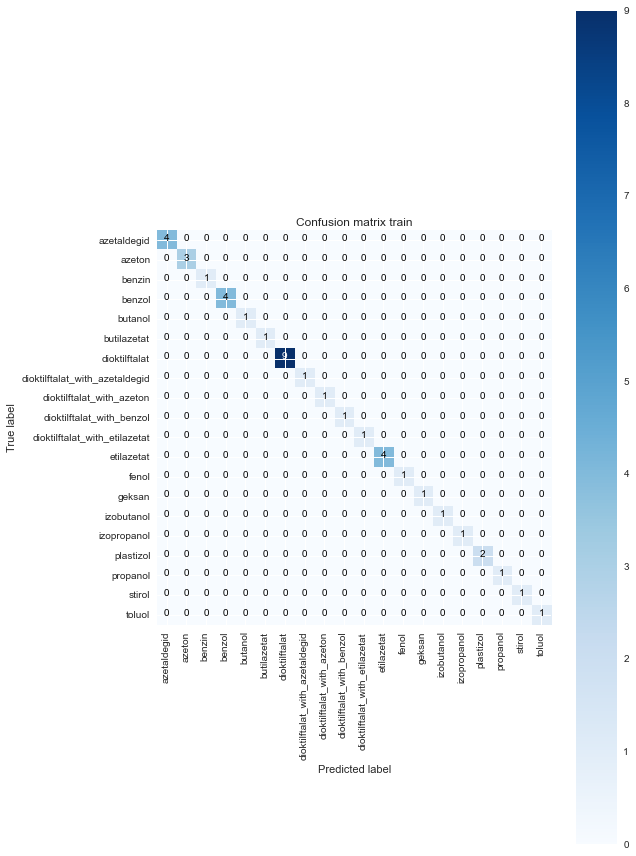

In [105]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(clf.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [106]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       1.00      1.00      1.00         4
                        azeton       1.00      1.00      1.00         3
                        benzin       1.00      1.00      1.00         1
                        benzol       1.00      1.00      1.00         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       1.00      1.00      1.00         9
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       1.00      1.00      1.00         1
     dioktilftalat_with_benzol       1.00      1.00      1.00         1
 dioktilftalat_with_etilazetat       1.00      1.00      1.00         1
                    etilazetat       1.00      1.00      1.00         4
                         fenol       1.00      1.00      1.00  

Посмотрим на multilabel.

In [107]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier( SVC(kernel='rbf', C=0.001, coef0=0.0,  gamma=0.01, decision_function_shape='ovo', probability=True) )
clf.fit(X_train_fmax, y_train)
y_score =  clf.predict(X_train_fmax) 
err_train = np.mean(y_train != y_score)
print ("svm train accuracy: ", 1 - err_train)

y_new_proba = clf.predict_proba(X_new_fmax)
y_test_true_labels = load_labels("true_labels.txt")
y_test_true_labels = [list(filter(None, lab)) for lab in y_test_true_labels]
for y_pred,y_tr,i in zip(y_new_proba,y_test_true_labels,range(len(X_new))):
    print (i+1)
    r1 = [(c,"{:.3f}".format(yy)) for c,yy in zip(mlb.classes_,y_pred)]
    sorted_by_second_1 = sorted(r1, key=lambda tup: tup[1], reverse=True)
    print (sorted_by_second_1[:6])
    print (set(y_tr))
    print ("------------------")

svm train accuracy:  0.95
1
[('dioktilftalat', '0.193'), ('azetaldegid', '0.122'), ('etilazetat', '0.109'), ('plastizol', '0.092'), ('benzol', '0.085'), ('azeton', '0.079')]
{'azeton', 'dioktilftalat'}
------------------
2
[('dioktilftalat', '0.193'), ('azetaldegid', '0.122'), ('etilazetat', '0.109'), ('plastizol', '0.092'), ('benzol', '0.085'), ('azeton', '0.079')]
{'azeton', 'dioktilftalat'}
------------------
3
[('dioktilftalat', '0.193'), ('azetaldegid', '0.122'), ('etilazetat', '0.109'), ('plastizol', '0.092'), ('benzol', '0.085'), ('azeton', '0.079')]
{'plastizol'}
------------------
4
[('dioktilftalat', '0.142'), ('azetaldegid', '0.122'), ('etilazetat', '0.104'), ('plastizol', '0.092'), ('azeton', '0.081'), ('benzol', '0.076')]
{'dioktilftalat_with_azetaldegid', 'izopropanol', 'izobutanol', 'butilazetat', 'toluol', 'dioktilftalat_with_etilazetat'}
------------------
5
[('dioktilftalat', '0.187'), ('azetaldegid', '0.123'), ('etilazetat', '0.109'), ('plastizol', '0.092'), ('benzol

# Learning on cross-correlation matrices

In [108]:
X_train, y_train_bin, X_new, mlb = load_dataset()

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)


Посмотрим на взаимную корреляцию сенсоров. Видно, что везде показания сильно коррелированы, характер корреляции - положительный. По матрицам взаимной кореляци можно выделить характерные признаки:
- Ацелальдегид (1 или 6 сенсор), однако показания не всегда точны
- ДОФ - там у всех сенсоров, кроме 6, взаимная корреляция близка к +1, в то время как 6 имеет сильную отрицательную корреляцию, более -0.5, ближе к -0.8. 
- Бензина и бензол - по сенсору 1 их матрциы похожи
- Гексан - определеяется двумя сенсорами - 1 и 6.
- Для изобутанола так же имеет определяющее значение сенсор 1.
- Для изопропанола - сенсор 6
- Пластизоль определяется сенсорами 1 (отрицательная корреляция) и 6 (слабая положительная)
- Для определения стирола решающую роль играют показания сенсора 5 - там взаимная корреляция гораздо ниже, чем у прочих
- Толуол - сенсор 6, однако корреляция сильня положительная
- Этилацетат - нулевой сенсор у одного объекта, средняя положительная корреляция, и 3 у объектов - сенсор 1
- ДОФ с ацетоном - сенсоры 0 и 6
- ДОФ с бензолом - сенсроы 5 и 6

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


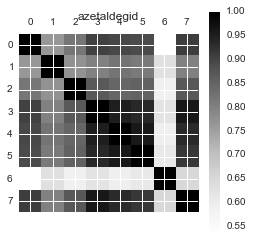

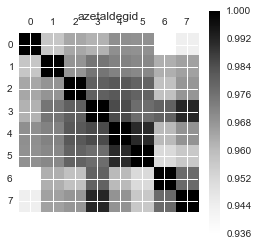

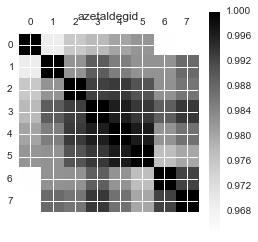

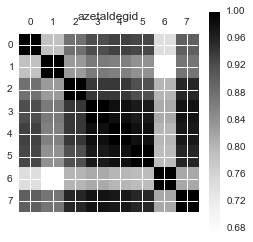

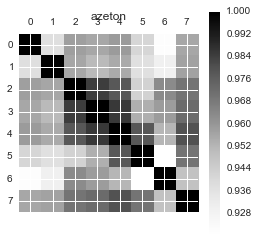

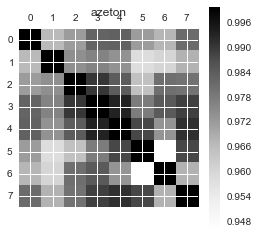

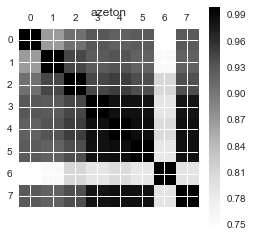

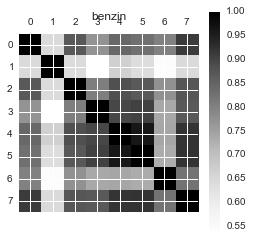

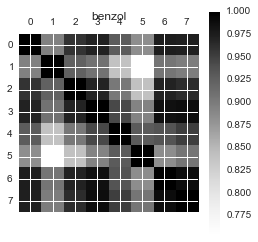

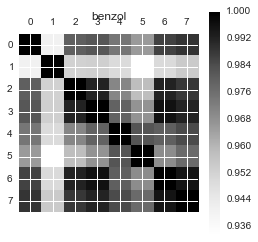

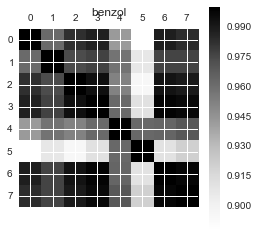

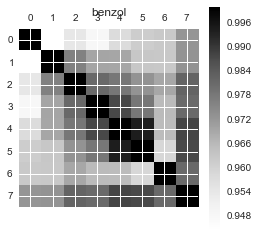

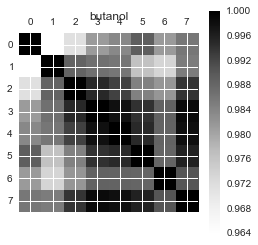

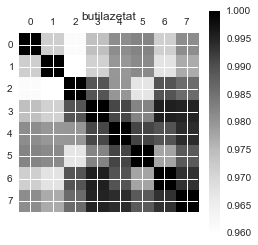

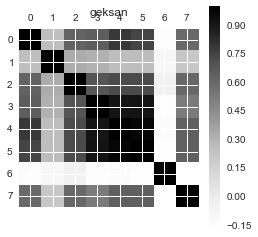

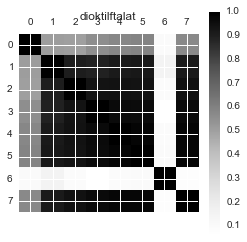

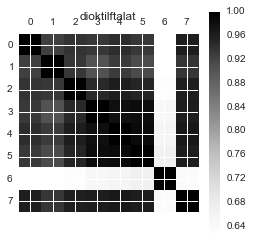

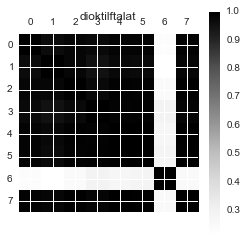

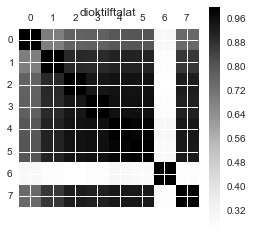

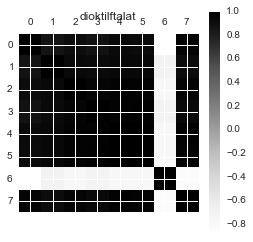

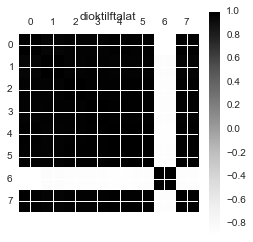

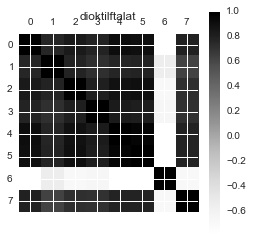

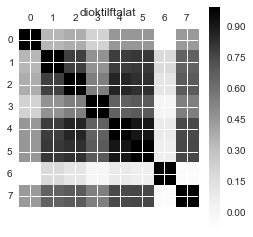

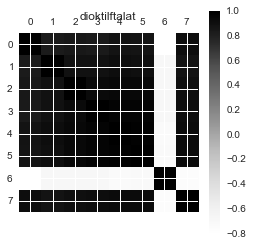

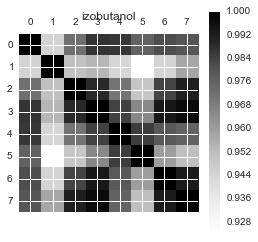

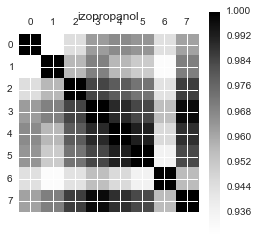

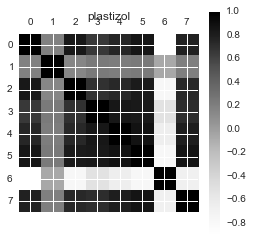

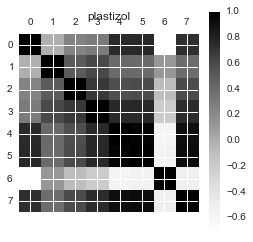

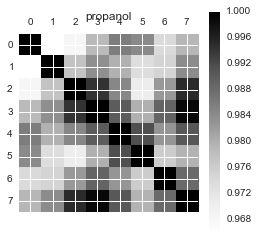

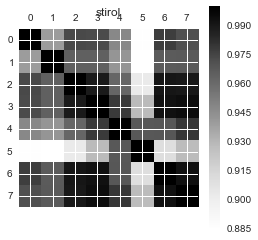

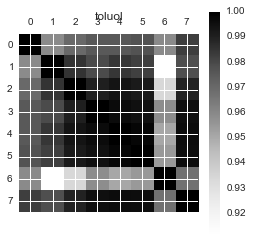

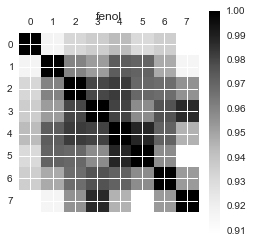

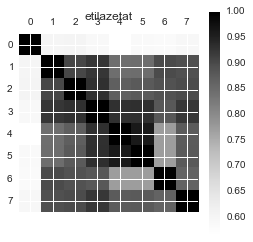

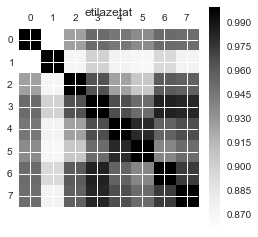

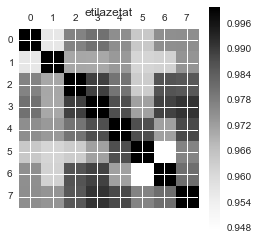

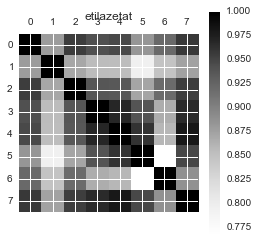

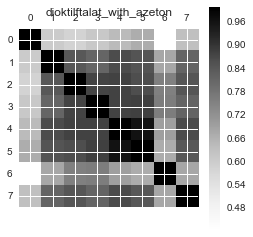

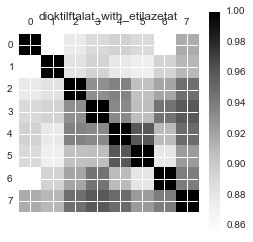

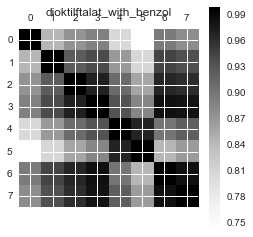

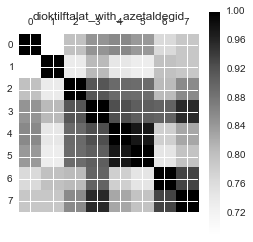

In [109]:
X_train_corr = []
for X, y in zip(X_train, y_train2):
    X = list(map(list, zip(*X)))
    df = pd.DataFrame(X, index=None, columns=["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"])
    X_train_corr.append(df.corr().as_matrix())
    plt.matshow(df.corr())
    plt.colorbar()
    plt.title(y)
#plt.close('all')

Посмотрим на матрицы взаимной корреляции игрушек. Сходные фигуры наблюдаются и здесь.

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


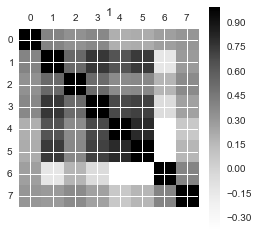

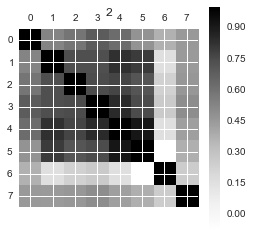

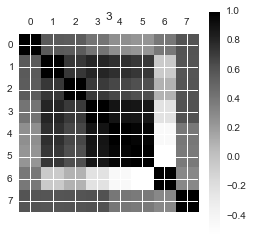

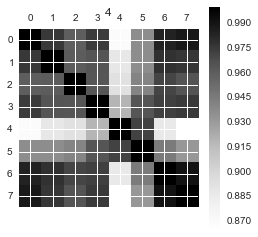

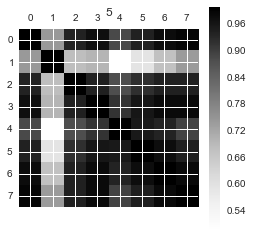

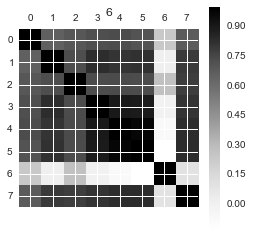

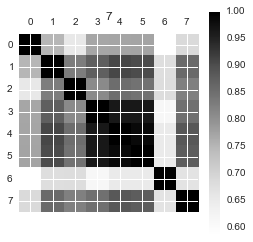

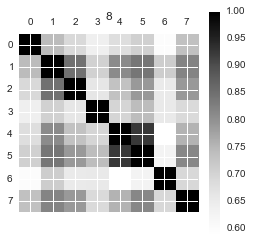

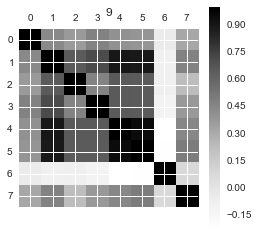

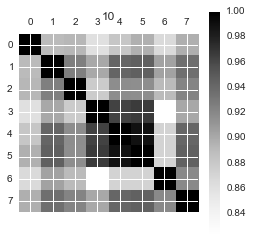

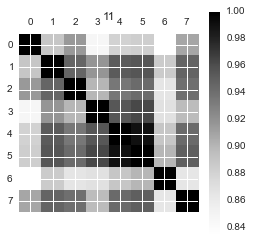

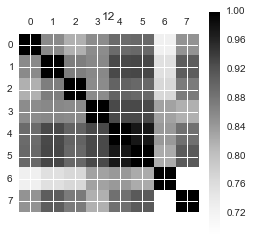

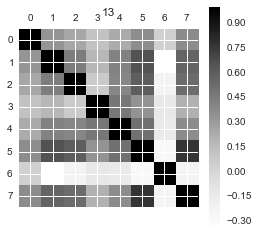

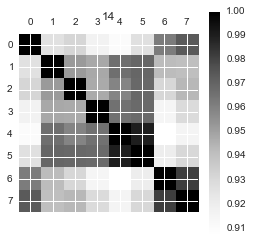

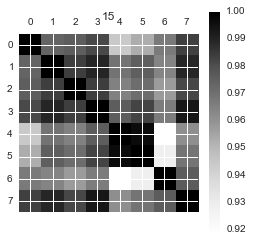

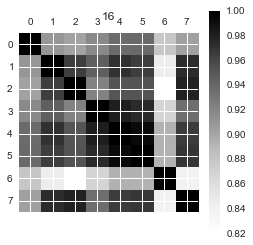

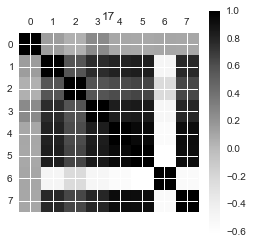

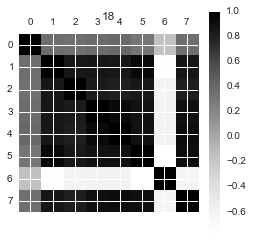

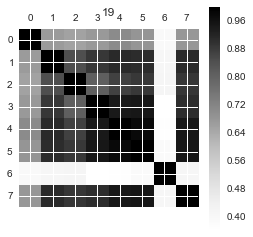

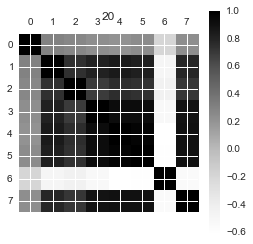

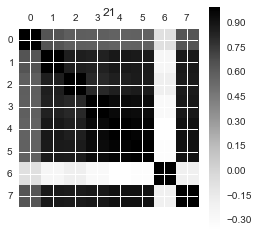

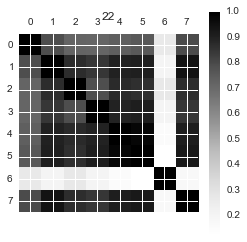

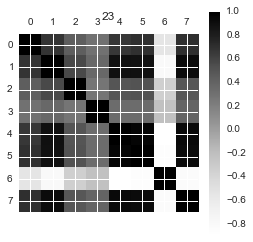

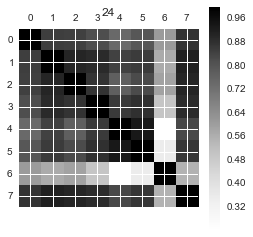

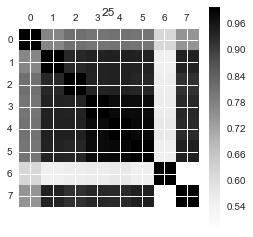

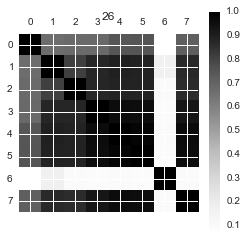

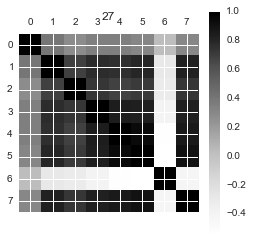

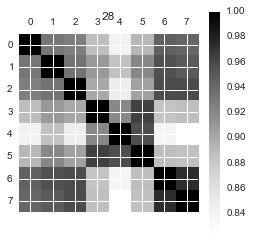

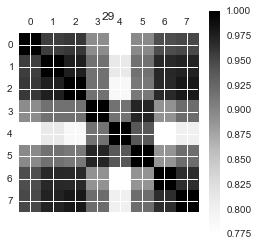

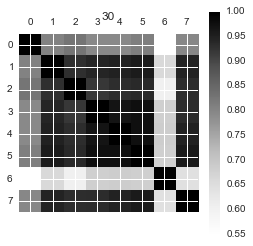

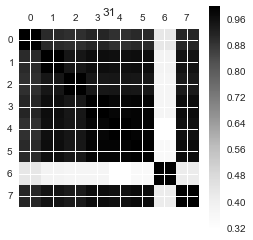

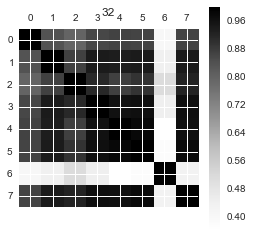

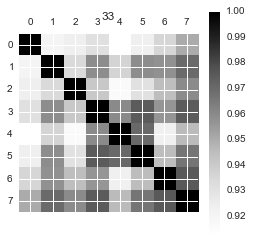

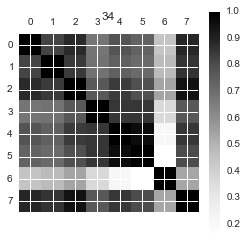

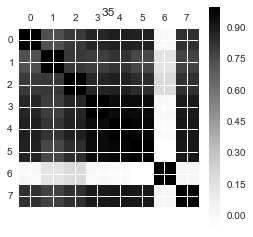

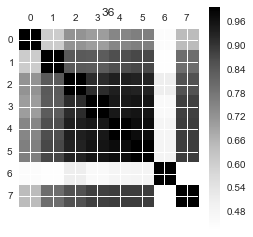

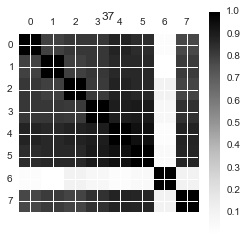

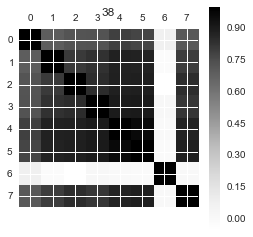

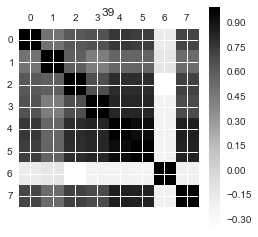

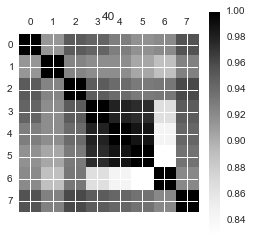

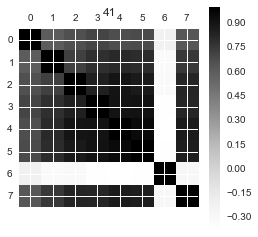

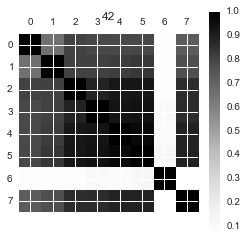

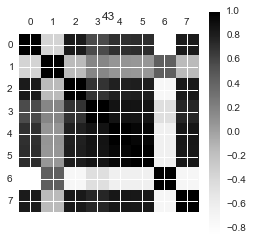

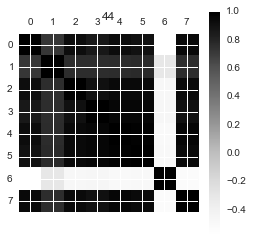

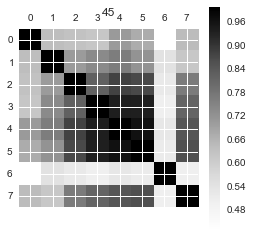

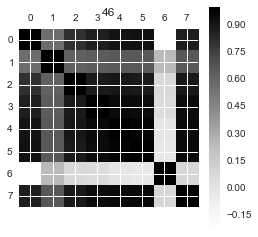

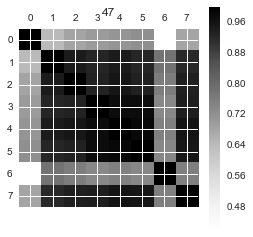

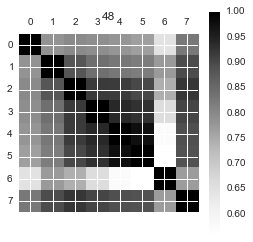

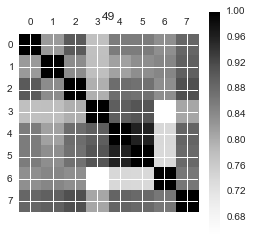

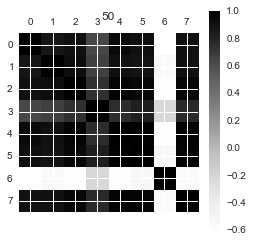

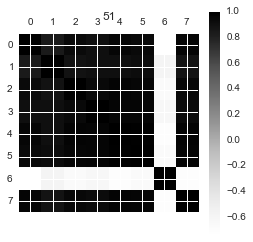

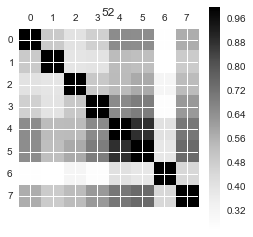

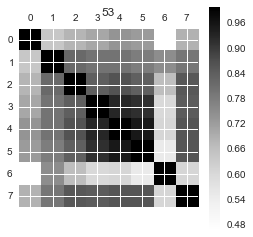

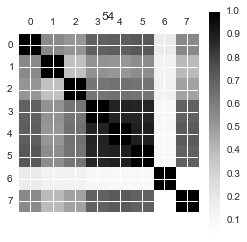

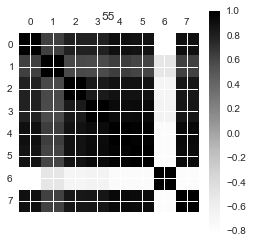

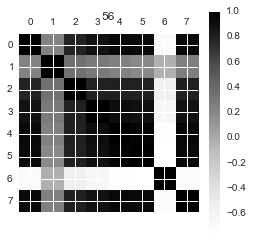

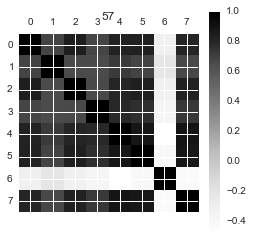

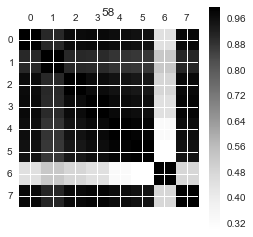

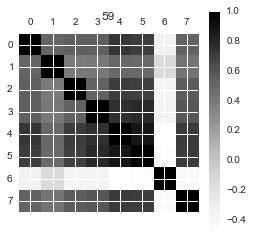

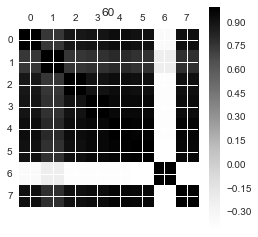

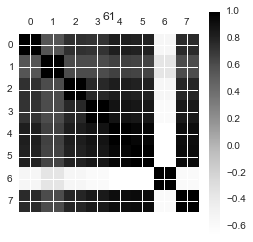

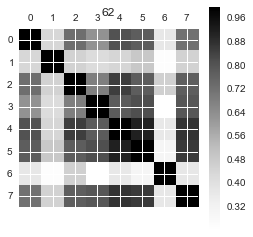

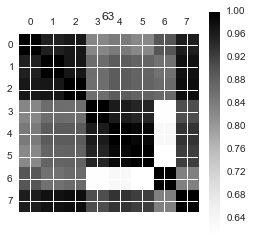

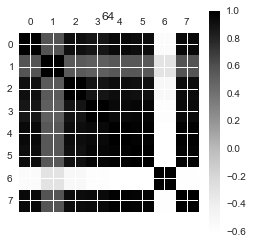

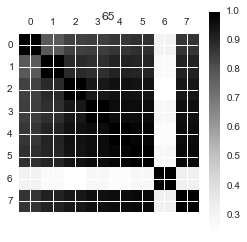

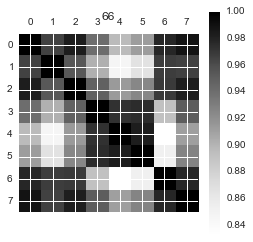

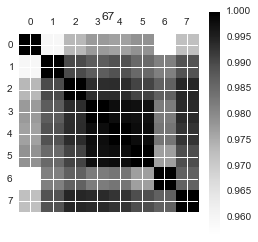

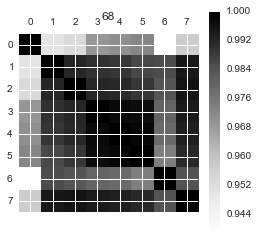

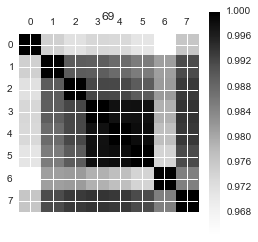

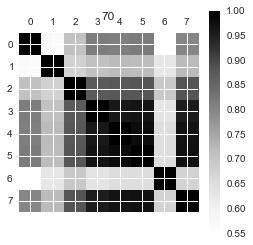

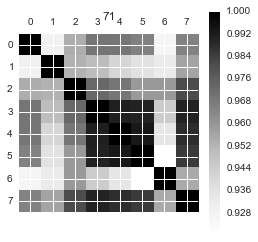

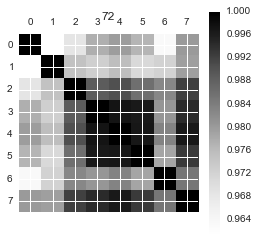

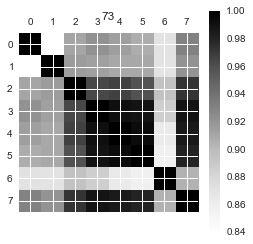

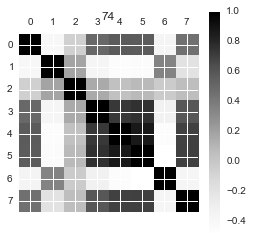

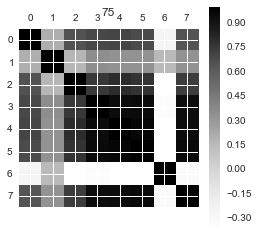

In [110]:
X_new_corr = []
for X, y in zip(X_new, range(1,76)):
    X = list(map(list, zip(*X)))
    df = pd.DataFrame(X, index=None, columns=["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"])
    X_new_corr.append(df.corr().as_matrix())
    plt.matshow(df.corr())
    plt.colorbar()
    plt.title(y)
#plt.close('all')

In [111]:
X_train_corr = np.array(X_train_corr)
n_samples = len(X_train_corr)
X_train_corr = X_train_corr.reshape((n_samples, -1))

In [112]:
X_new_corr = np.array(X_new_corr)
n_samples = len(X_new_corr)
X_new_corr = X_new_corr.reshape((n_samples, -1))

In [113]:
#df = pd.DataFrame(X_train_corr, index=None, columns=None)
#df.describe()

In [114]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_corr, y_train2)
y_score = clf.predict(X_train_corr)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.3


Точность явно ниже ожидаемого.

Confusion matrix, without normalization


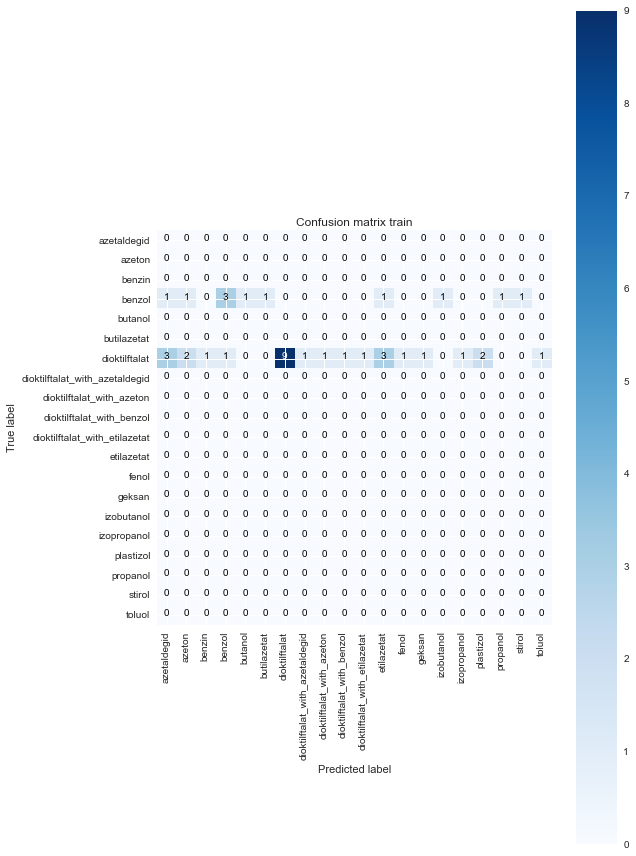

In [115]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(clf.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [116]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       0.00      0.00      0.00         4
                        azeton       0.00      0.00      0.00         3
                        benzin       0.00      0.00      0.00         1
                        benzol       0.27      0.75      0.40         4
                       butanol       0.00      0.00      0.00         1
                   butilazetat       0.00      0.00      0.00         1
                 dioktilftalat       0.31      1.00      0.47         9
dioktilftalat_with_azetaldegid       0.00      0.00      0.00         1
     dioktilftalat_with_azeton       0.00      0.00      0.00         1
     dioktilftalat_with_benzol       0.00      0.00      0.00         1
 dioktilftalat_with_etilazetat       0.00      0.00      0.00         1
                    etilazetat       0.00      0.00      0.00         4
                         fenol       0.00      0.00      0.00  

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Попробуем подобрать параметры.

In [117]:
kfold = model_evaluation(X_train_corr, y_train2, 2)  

from sklearn.svm import SVC  
from sklearn.grid_search import GridSearchCV
Gammas = [0.001, 0.01, 1, 10]
kernels = ['rbf', 'linear', 'sigmoid']
decision_function = ['ovo', 'ovr']
coefs = [0.0, 0.5, 1.0, 10.0, 100.0]
class_weight = ['balanced', 'auto']
Cs = [0.001, 0.01, 1, 10]

svc_grid = GridSearchCV(estimator = (SVC()), 
    param_grid = {'C': Cs, 'gamma': Gammas, 'kernel': kernels, 
    'decision_function_shape': decision_function,
    'coef0': coefs, 'class_weight': class_weight },
    cv = kfold, n_jobs = 1)

svc_grid.fit(X_train_corr, y_train2)

print ("best score:", svc_grid.best_score_)
print ("best params: ", svc_grid.best_params_)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated

best score: 0.25
best params:  {'C': 1, 'kernel': 'rbf', 'coef0': 0.0, 'decision_function_shape': 'ovo', 'class_weight': 'auto', 'gamma': 1}


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


In [118]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1, coef0=0.0, class_weight='auto', gamma=1, decision_function_shape='ovo')
clf.fit(X_train_corr, y_train2)
y_score = clf.predict(X_train_corr)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.675


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Результат после подбора параметров улучшился вдвое. Посмотрим, как поведёт себя алгоритм на multilabel-задаче.

Confusion matrix, without normalization


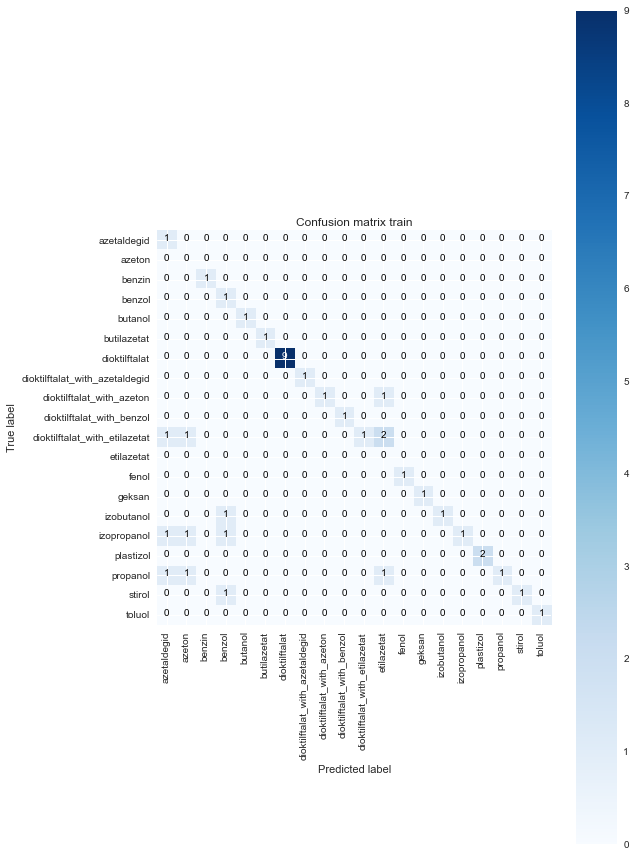

In [119]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(clf.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [120]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       1.00      0.25      0.40         4
                        azeton       0.00      0.00      0.00         3
                        benzin       1.00      1.00      1.00         1
                        benzol       1.00      0.25      0.40         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       1.00      1.00      1.00         9
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       0.50      1.00      0.67         1
     dioktilftalat_with_benzol       1.00      1.00      1.00         1
 dioktilftalat_with_etilazetat       0.20      1.00      0.33         1
                    etilazetat       0.00      0.00      0.00         4
                         fenol       1.00      1.00      1.00  

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier( SVC(kernel='rbf', C=1, coef0=0.0, gamma=1, decision_function_shape='ovo', probability=True) )
clf.fit(X_train_corr, y_train)
y_score =  clf.predict(X_train_corr) 
err_train = np.mean(y_train != y_score)
print ("svm train accuracy: ", 1 - err_train)

y_new_proba = clf.predict_proba(X_new_corr)
y_test_true_labels = load_labels("true_labels.txt")
y_test_true_labels = [list(filter(None, lab)) for lab in y_test_true_labels]
for y_pred,y_tr,i in zip(y_new_proba,y_test_true_labels,range(len(X_new))):
    print (i+1)
    r1 = [(c,"{:.3f}".format(yy)) for c,yy in zip(mlb.classes_,y_pred)]
    sorted_by_second_1 = sorted(r1, key=lambda tup: tup[1], reverse=True)
    print (sorted_by_second_1[:6])
    print (set(y_tr))
    print ("------------------")


svm train accuracy:  0.96375
1
[('plastizol', '0.509'), ('dioktilftalat', '0.399'), ('azetaldegid', '0.113'), ('benzol', '0.110'), ('etilazetat', '0.055'), ('azeton', '0.049')]
{'azeton', 'dioktilftalat'}
------------------
2
[('dioktilftalat', '0.469'), ('plastizol', '0.403'), ('azetaldegid', '0.113'), ('benzol', '0.110'), ('etilazetat', '0.060'), ('azeton', '0.049')]
{'azeton', 'dioktilftalat'}
------------------
3
[('plastizol', '0.487'), ('dioktilftalat', '0.411'), ('azetaldegid', '0.113'), ('benzol', '0.110'), ('etilazetat', '0.056'), ('azeton', '0.049')]
{'plastizol'}
------------------
4
[('etilazetat', '0.182'), ('benzol', '0.145'), ('azetaldegid', '0.111'), ('azeton', '0.082'), ('dioktilftalat', '0.050'), ('izopropanol', '0.046')]
{'dioktilftalat_with_azetaldegid', 'izopropanol', 'izobutanol', 'butilazetat', 'toluol', 'dioktilftalat_with_etilazetat'}
------------------
5
[('benzol', '0.136'), ('dioktilftalat', '0.129'), ('azetaldegid', '0.114'), ('plastizol', '0.096'), ('azeta

# Principal component analysis of each matrix

In [122]:
X_train, y_train_bin, X_new, mlb = load_dataset()

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)


In [123]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

Попутно посмотрим на отношение столбцов в матрицах. Ранг всех матриц равен 8 => имеем 8 линейно независимых столбцов.

In [124]:
from numpy.linalg import matrix_rank 

X_train2 = []
for X, i in zip(X_train, range(1,len(X_train)+1)):
    X = list(map(list, zip(*X)))
    pca.fit(X)
    X_train2.append(list(pca.transform(X)))  
    print (i, " -> ", '%.4f' % pca.explained_variance_ratio_[0], "; число линейно независимых строк и столбцов: ", matrix_rank(X))

1  ->  0.9343 ; число линейно независимых строк и столбцов:  8
2  ->  0.9818 ; число линейно независимых строк и столбцов:  8
3  ->  0.9917 ; число линейно независимых строк и столбцов:  8
4  ->  0.9657 ; число линейно независимых строк и столбцов:  8
5  ->  0.9743 ; число линейно независимых строк и столбцов:  8
6  ->  0.9868 ; число линейно независимых строк и столбцов:  8
7  ->  0.9768 ; число линейно независимых строк и столбцов:  8
8  ->  0.8936 ; число линейно независимых строк и столбцов:  8
9  ->  0.9714 ; число линейно независимых строк и столбцов:  8
10  ->  0.9884 ; число линейно независимых строк и столбцов:  8
11  ->  0.9916 ; число линейно независимых строк и столбцов:  8
12  ->  0.9842 ; число линейно независимых строк и столбцов:  8
13  ->  0.9978 ; число линейно независимых строк и столбцов:  8
14  ->  0.9903 ; число линейно независимых строк и столбцов:  8
15  ->  0.8803 ; число линейно независимых строк и столбцов:  8
16  ->  0.9561 ; число линейно независимых строк 

Видно, что первая компонента объясняет не менее 88% процентов дисперсии исходной модели. Для большинства веществ-маркеров эта цифра стремится к 100%. Посмотрим, что происходит с главными компонентами в матрицаз обеих видов. Синий - это пример матрицы, где объяснённаяя дисперсия первой компоненты стремится к 100%, зелёный - 88%. На обоих графиках поведение одинаковое.

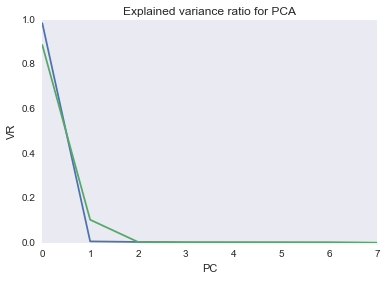

In [125]:
pca = PCA()
pca.fit(X_train[6])
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio for PCA")
plt.xlabel('PC')
plt.ylabel('VR')
plt.grid()
pca.fit(X_train[39])
plt.plot(pca.explained_variance_ratio_)

In [126]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

Попутно посмотрим на отношение столбцов в матрицах. Ранг всех матриц равен 8 => имеем 8 линейно независимых столбцов.

In [127]:
from numpy.linalg import matrix_rank 

X_new2 = []
for X,i in zip(X_new, range(1,len(X_new)+1)):
    X = list(map(list, zip(*X)))
    pca.fit(X)
    X_new2.append(list(pca.transform(X)))
    print (i, " -> ", '%.4f' % pca.explained_variance_ratio_[0], "; число линейно независимых строк и столбцов: ", matrix_rank(X))

1  ->  0.7535 ; число линейно независимых строк и столбцов:  8
2  ->  0.8644 ; число линейно независимых строк и столбцов:  8
3  ->  0.8620 ; число линейно независимых строк и столбцов:  8
4  ->  0.9616 ; число линейно независимых строк и столбцов:  8
5  ->  0.9515 ; число линейно независимых строк и столбцов:  8
6  ->  0.8944 ; число линейно независимых строк и столбцов:  8
7  ->  0.9553 ; число линейно независимых строк и столбцов:  8
8  ->  0.8322 ; число линейно независимых строк и столбцов:  8
9  ->  0.8496 ; число линейно независимых строк и столбцов:  8
10  ->  0.9605 ; число линейно независимых строк и столбцов:  8
11  ->  0.9690 ; число линейно независимых строк и столбцов:  8
12  ->  0.9392 ; число линейно независимых строк и столбцов:  8
13  ->  0.5927 ; число линейно независимых строк и столбцов:  8
14  ->  0.9555 ; число линейно независимых строк и столбцов:  8
15  ->  0.9822 ; число линейно независимых строк и столбцов:  8
16  ->  0.9828 ; число линейно независимых строк 

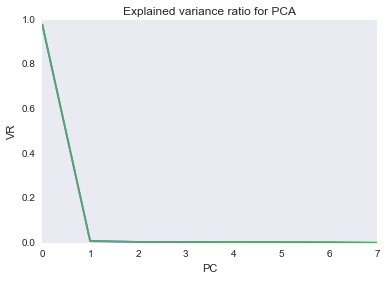

In [128]:
pca = PCA()
pca.fit(X_new[6])
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio for PCA")
plt.xlabel('PC')
plt.ylabel('VR')
plt.grid()
pca.fit(X_new[39])
plt.plot(pca.explained_variance_ratio_)

Видно, что для игрушек происходит то же самое

Итак, получили представление каждого сенсора в виде одного числа. Теперь посмотрим на отношения внутри полученного вектора.

## Linear discriminant analysis

Превращение в двухмерную матрицу (до этого шага имелась одна лишняя "пустая" размерность)

In [129]:
X_train2 = np.array(X_train2)
print (X_train2.shape)
nsamples00, nx, ny = X_train2.shape
X_train2 = X_train2.reshape((nsamples00,nx*ny))        

X_new2 = np.array(X_new2)
print (X_new2.shape)
nsamples00, nx, ny = X_new2.shape
X_new2 = X_new2.reshape((nsamples00,nx*ny))  

(40, 121, 1)
(75, 121, 1)


При этом, если мы и дальше планируем развивать этот подход, нас интересует именно такое представление этих данных, чтобы расстояние между классами было максимально. Иными словами, радикально уменьшая размерность обучающего множества со 121-мерного до 8-, а то и 2-мерного, нужно позаботиться о качестве распознавания. Поскольку линейный дискриминант - это supervised-метод, он даст нам именно то, что нужно.

In [130]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda =  LinearDiscriminantAnalysis(solver='svd') 

In [131]:
y_train2 = load_labels("data/labels_all.txt")
lda.fit(X_train2, y_train2)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [132]:
#print (lda.explained_variance_ratio_)

Первые 2 фактора дадут нам 95% дисперии исходной модели.

In [133]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda =  LinearDiscriminantAnalysis(n_components=2, solver='svd') 
lda.fit(X_train2, y_train2)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [134]:
X = lda.transform(X_train2)
X_new2 = lda.transform(X_new2)

In [135]:
lda.get_params().keys()

dict_keys(['tol', 'priors', 'shrinkage', 'store_covariance', 'solver', 'n_components'])

In [136]:
kfold = model_evaluation(X_train2, y_train2, 2)  

from sklearn.grid_search import GridSearchCV
solvers = ['svd']
n_components  = [1, 2, 3, 4, 5, 6, 7, 8]

lda_grid = GridSearchCV(estimator = LinearDiscriminantAnalysis(), 
    param_grid = { 'solver': solvers, 'n_components': n_components},
    cv = kfold, n_jobs = 1)

lda_grid.fit(X_train2, y_train2)

print ("best score:", lda_grid.best_score_)
print ("best params: ", lda_grid.best_params_)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variabl

best score: 0.05
best params:  {'solver': 'svd', 'n_components': 1}


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Обучим модель и посмотрим, с какой точностью LDA способен работать с этими данными.

In [137]:
y_score = lda.predict(X_train2)
err_train = np.mean(y_train2 != y_score)
print ("LDA train accuracy: ", 1 - err_train)

LDA train accuracy:  0.8


Точность составляет 80%, а анализ матрицы ошибок показывает, что:
- Модель хорошо различает: ацетальдегид, ацетон, бензин, бензол, бутанол, бутилацетат, ДОФ с ацетальдегидом, ДОФ с ацетоном, ДОФ с бензолом, фенол, изобутанол, изопропанол, пропанол, стирол, толуол.
- Для ацетона - 2 объекта назначены правильно, 1 ошибочно отнесён в ДОФ
- Для ДОФ - 8 объектов верны, 1 объект ошибочно назначен этилацетатом, 1 гексаном и 1 пластизолью
- ДОФ с этилацетатом перепутана с чистым этилацетатом

Confusion matrix, without normalization


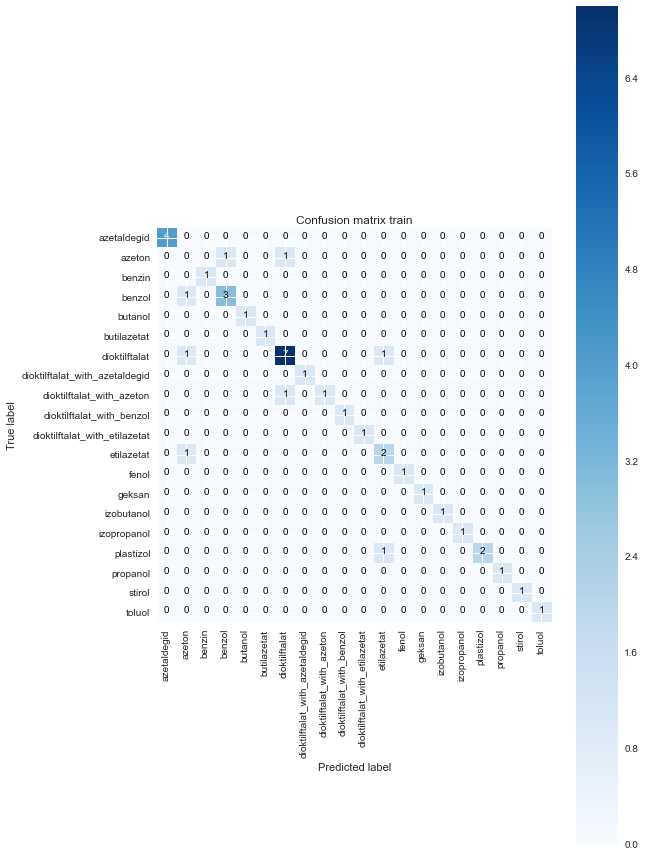

In [138]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(lda.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [139]:
#from sklearn.metrics import classification_report
#print(classification_report(y_train2, y_score, target_names=clf.classes_))

In [140]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier( LinearDiscriminantAnalysis(n_components=2, solver='svd')  )
clf.fit(X_train_corr, y_train)
y_score =  clf.predict(X_train_corr) 
err_train = np.mean(y_train != y_score)
print ("LDA train accuracy: ", 1 - err_train)

y_new_proba = clf.predict_proba(X_new_corr)
y_test_true_labels = load_labels("true_labels.txt")
y_test_true_labels = [list(filter(None, lab)) for lab in y_test_true_labels]
for y_pred,y_tr,i in zip(y_new_proba,y_test_true_labels,range(len(X_new))):
    print (i+1)
    r1 = [(c,"{:.3f}".format(yy)) for c,yy in zip(mlb.classes_,y_pred)]
    sorted_by_second_1 = sorted(r1, key=lambda tup: tup[1], reverse=True)
    print (sorted_by_second_1[:6])
    print (set(y_tr))
    print ("------------------")


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are

LDA train accuracy:  0.995
1
[('benzol', '1.000'), ('butanol', '1.000'), ('butilazetat', '1.000'), ('etilazetat', '1.000'), ('izobutanol', '1.000'), ('propanol', '1.000')]
{'azeton', 'dioktilftalat'}
------------------
2
[('azetaldegid_with_dioktilftalat', '1.000'), ('azeton', '1.000'), ('benzol', '1.000'), ('etilazetat', '1.000'), ('geksan', '1.000'), ('izopropanol', '1.000')]
{'azeton', 'dioktilftalat'}
------------------
3
[('azetaldegid_with_dioktilftalat', '1.000'), ('benzol', '1.000'), ('butanol', '1.000'), ('butilazetat', '1.000'), ('etilazetat', '1.000'), ('izobutanol', '1.000')]
{'plastizol'}
------------------
4
[('benzol', '1.000'), ('butanol', '1.000'), ('butilazetat', '1.000'), ('etilazetat', '1.000'), ('izobutanol', '1.000'), ('propanol', '1.000')]
{'dioktilftalat_with_azetaldegid', 'izopropanol', 'izobutanol', 'butilazetat', 'toluol', 'dioktilftalat_with_etilazetat'}
------------------
5
[('azeton', '1.000'), ('dioktilftalat_with_etilazetat', '1.000'), ('etilazetat', '1.

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [141]:
df = pd.DataFrame(X, index=None, columns=["C0", "C1"])

In [142]:
df.describe()

,C0,C1
count,4.000000e+01,4.000000e+01
mean,-2.498002e-16,-5.412337e-16
std,2.618779e+00,1.595486e+00
min,-8.277857e+00,-3.739733e+00
25%,-1.163579e+00,-5.007435e-01
50%,8.247109e-01,6.734368e-02
75%,1.731482e+00,9.654094e-01
max,3.585169e+00,5.395704e+00


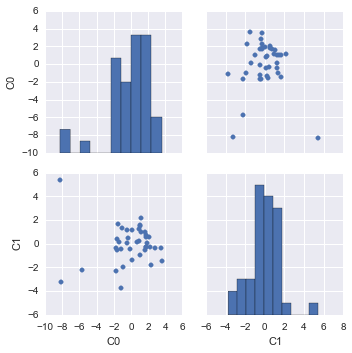

In [143]:
g = sns.pairplot(df, kind="scatter")

Нормализуем:

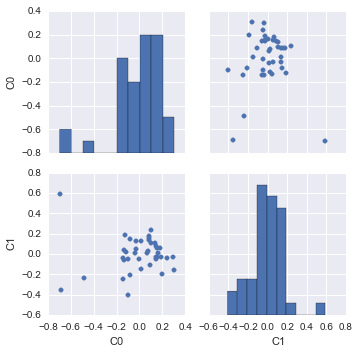

In [144]:
df = (df - df.mean()) / (df.max() - df.min())
g = sns.pairplot(df, kind="scatter")

In [145]:
df.describe()

,C0,C1
count,4.000000e+01,4.000000e+01
mean,-1.387779e-18,6.938894e-19
std,2.207514e-01,1.746481e-01
min,-6.977863e-01,-4.093655e-01
25%,-9.808449e-02,-5.481331e-02
50%,6.951944e-02,7.371697e-03
75%,1.459562e-01,1.056774e-01
max,3.022137e-01,5.906345e-01


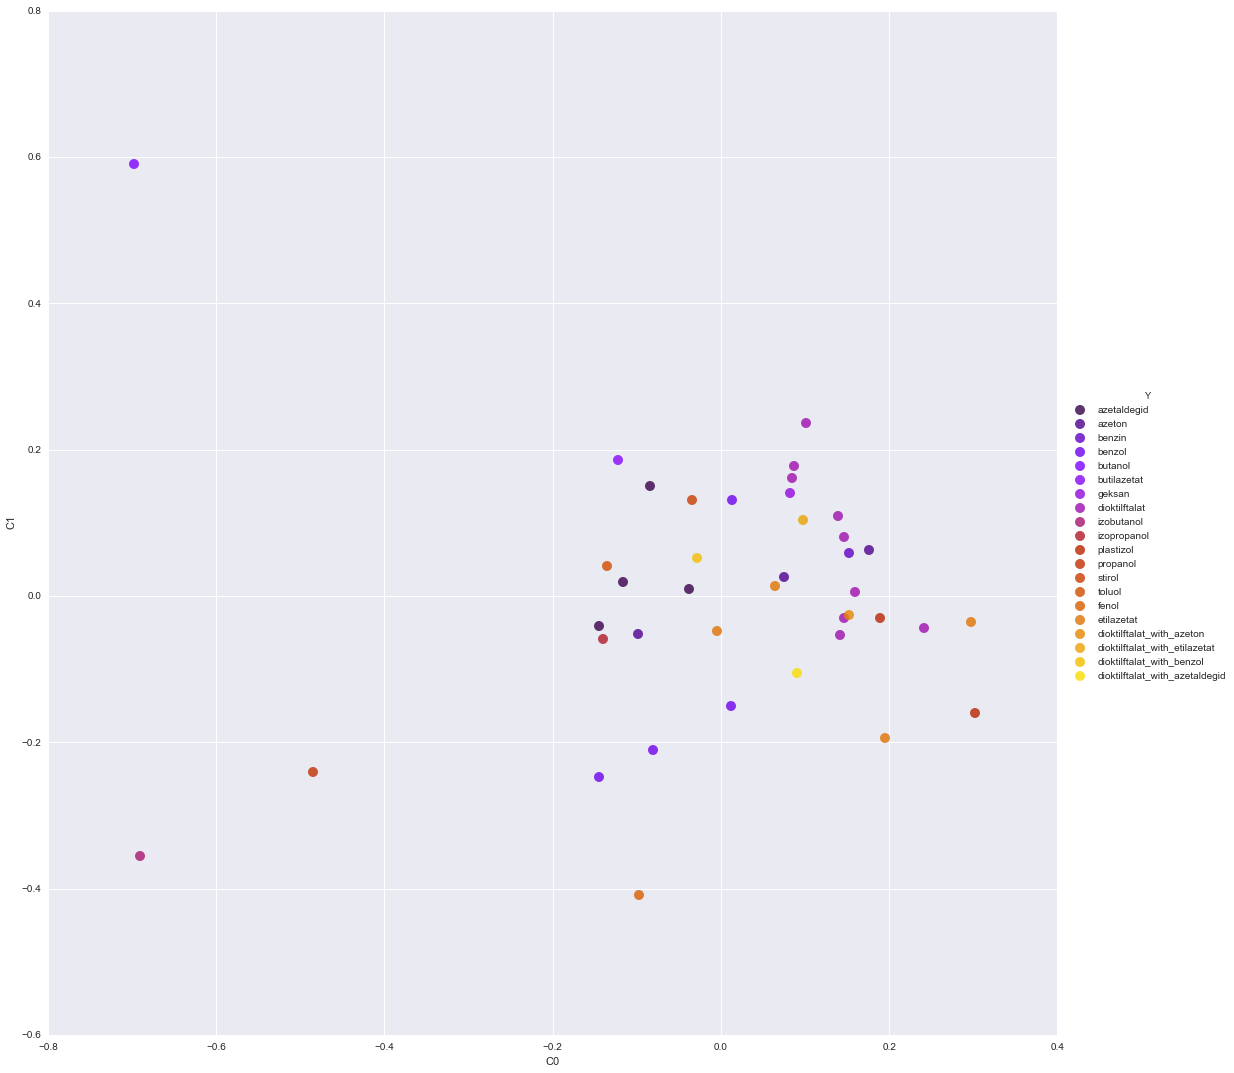

In [146]:
df["Y"] = y_train2
g = sns.lmplot(x="C0", y="C1", hue="Y", fit_reg=False, scatter_kws={"s": 100}, data=df, palette="gnuplot", size=15)
plt.savefig("")

# Learning on data without outliers

In [147]:
X_train, y_train_bin, X_new, mlb = load_dataset()

X_train_out = load_data("data/data_all_outliers.txt")
y_train_out = load_labels("data/labels_all_outliers.txt")

print ("Data without outliers: ", np.array(X_train_out).shape)

y_train_out_2 = []
for item in y_train_out:
    y_train_out_2.append([item])
y_train_out_2 = mlb.fit_transform(y_train_out_2)

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)
Data without outliers:  (37, 8, 121)


In [148]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

In [149]:
from numpy.linalg import matrix_rank 
X_train2 = []
for X,i in zip(X_train_out, range(1,len(X_train_out)+1)):
    X = list(map(list, zip(*X)))
    pca.fit(X)
    X_train2.append(list(pca.transform(X)))
    print (i, " -> ", '%.4f' % pca.explained_variance_ratio_[0], "; число линейно независимых строк и столбцов: ", matrix_rank(X))

1  ->  0.9818 ; число линейно независимых строк и столбцов:  8
2  ->  0.9917 ; число линейно независимых строк и столбцов:  8
3  ->  0.9657 ; число линейно независимых строк и столбцов:  8
4  ->  0.9743 ; число линейно независимых строк и столбцов:  8
5  ->  0.9868 ; число линейно независимых строк и столбцов:  8
6  ->  0.9768 ; число линейно независимых строк и столбцов:  8
7  ->  0.8936 ; число линейно независимых строк и столбцов:  8
8  ->  0.9714 ; число линейно независимых строк и столбцов:  8
9  ->  0.9884 ; число линейно независимых строк и столбцов:  8
10  ->  0.9916 ; число линейно независимых строк и столбцов:  8
11  ->  0.9842 ; число линейно независимых строк и столбцов:  8
12  ->  0.9978 ; число линейно независимых строк и столбцов:  8
13  ->  0.9903 ; число линейно независимых строк и столбцов:  8
14  ->  0.8803 ; число линейно независимых строк и столбцов:  8
15  ->  0.9721 ; число линейно независимых строк и столбцов:  8
16  ->  0.9945 ; число линейно независимых строк 

In [150]:
from numpy.linalg import matrix_rank 
X_new2 = []
for X,i in zip(X_new, range(1,len(X_new)+1)):
    X = list(map(list, zip(*X)))
    pca.fit(X)
    X_new2.append(list(pca.transform(X)))
    print (i, " -> ", '%.4f' % pca.explained_variance_ratio_[0], "; число линейно независимых строк и столбцов: ", matrix_rank(X))

1  ->  0.7535 ; число линейно независимых строк и столбцов:  8
2  ->  0.8644 ; число линейно независимых строк и столбцов:  8
3  ->  0.8620 ; число линейно независимых строк и столбцов:  8
4  ->  0.9616 ; число линейно независимых строк и столбцов:  8
5  ->  0.9515 ; число линейно независимых строк и столбцов:  8
6  ->  0.8944 ; число линейно независимых строк и столбцов:  8
7  ->  0.9553 ; число линейно независимых строк и столбцов:  8
8  ->  0.8322 ; число линейно независимых строк и столбцов:  8
9  ->  0.8496 ; число линейно независимых строк и столбцов:  8
10  ->  0.9605 ; число линейно независимых строк и столбцов:  8
11  ->  0.9690 ; число линейно независимых строк и столбцов:  8
12  ->  0.9392 ; число линейно независимых строк и столбцов:  8
13  ->  0.5927 ; число линейно независимых строк и столбцов:  8
14  ->  0.9555 ; число линейно независимых строк и столбцов:  8
15  ->  0.9822 ; число линейно независимых строк и столбцов:  8
16  ->  0.9828 ; число линейно независимых строк 

In [151]:
X_train2 = np.array(X_train2)
print (X_train2.shape)
nsamples00, nx, ny = X_train2.shape
X_train2 = X_train2.reshape((nsamples00,nx*ny))        

X_new2 = np.array(X_new2)
print (X_new2.shape)
nsamples00, nx, ny = X_new2.shape
X_new2 = X_new2.reshape((nsamples00,nx*ny))  

(37, 121, 1)
(75, 121, 1)


In [152]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda =  LinearDiscriminantAnalysis(solver='svd') 
y_train2 = load_labels("data/labels_all_outliers.txt")
lda.fit(X_train2, y_train2)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [153]:
X = lda.transform(X_train2)
X_new2 = lda.transform(X_new2)

In [154]:
y_score = lda.predict(X_train2)
err_train = np.mean(y_train2 != y_score)
print ("LDA train accuracy: ", 1 - err_train)

LDA train accuracy:  0.756756756757


Удаление выбросов уменьшает точность.

In [155]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=lda.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       1.00      0.67      0.80         3
                        azeton       0.00      0.00      0.00         3
                        benzin       1.00      1.00      1.00         1
                        benzol       0.60      0.75      0.67         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       0.75      0.86      0.80         7
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       1.00      1.00      1.00         1
     dioktilftalat_with_benzol       1.00      1.00      1.00         1
 dioktilftalat_with_etilazetat       0.50      1.00      0.67         1
                    etilazetat       0.50      0.50      0.50         4
                         fenol       1.00      1.00      1.00  